# 인물사진 카메라 기능 적용해보기🎨
- 인물사진모드 및 크로마키 합성을 수행해본다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. Out focusing

### 1.1 Load the Images

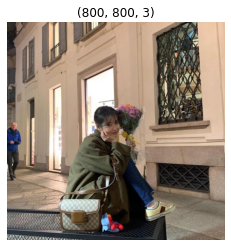

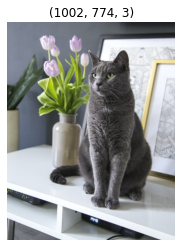

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
person_org = cv2.imread(img_path + 'travel.jpg')
cat_org = cv2.imread(img_path + 'greycat.jpg')


plt.imshow(cv2.cvtColor(person_org, cv2.COLOR_BGR2RGB))
plt.title(person_org.shape)
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(cat_org, cv2.COLOR_BGR2RGB))
plt.title(cat_org.shape)
plt.axis('off')
plt.show()

### 1.2 Semantic segmentation

1. DeepLabModel 구조를 가지고 pretrained weight 를 학습한다.
2. 준비된 이미지를 네트워크에 입력한다.
3. 라벨을 기준으로 마스크를 생성하여 구분된 객체를 검출한다.
4. resize 된 mask를 원본 이미지 크기로 되돌려준다.

### Model Preparation - DeepLab

구글에서 제공하는 DeepLab 모델 구조를 그대로 사용해 DeepLabModel 클래스를 만든다

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    # 세그맨테이션을 수행하는 함수
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### Load pretrained weight from tensorflow/modesl

구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화 해준다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전이다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


### Run the model

준비해준 이미지를 네트워크에 입력한다.resize된 이미지와 segmentation map이 생성된다.

In [5]:
person_resized, seg_map_person = MODEL.run(person_org)
print (person_org.shape, person_resized.shape, seg_map_person.max()) #segmentation map 라벨에서 가장 큰 값

cat_resized, seg_map_cat = MODEL.run(cat_org)
print (cat_org.shape, cat_resized.shape, seg_map_cat.max())

(800, 800, 3) (513, 513, 3) 16
(1002, 774, 3) (513, 396, 3) 16


DeepLab은 PASCAL VOC의 라벨로 학습되었고 라벨 종류는 아래와 같다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [7]:
[LABEL_NAMES[i] for i in np.unique(seg_map_person)]

['background', 'person', 'pottedplant']

In [8]:
print("the person image have",len(np.unique(seg_map_person)),"classes", [LABEL_NAMES[i] for i in np.unique(seg_map_person)])
print("the cat image have", len(np.unique(seg_map_cat)),"classes", [LABEL_NAMES[i] for i in np.unique(seg_map_cat)])

the person image have 3 classes ['background', 'person', 'pottedplant']
the cat image have 5 classes ['background', 'bottle', 'cat', 'diningtable', 'pottedplant']


seg_map에서 'person' 라벨을 가진 영역만 검출하려고 한다. 마스크를 만들고 시각화 해본다.

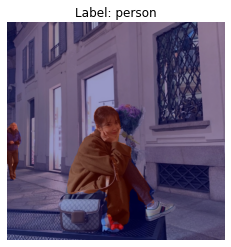

In [9]:
img_show = person_resized.copy()
seg_map_person = np.where(seg_map_person == 15, 15, 0) # 예측 중 사람만 추출
person_mask = seg_map_person * (255/seg_map_person.max()) # 255 normalization, 원본이미지에 그림형태로 출력하기 위해
person_mask = person_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(person_mask, cv2.COLORMAP_JET) # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("Label: person")
plt.axis('off')
plt.show()

seg_map에서 'cat' 라벨을 가진 영역만 검출하려고 한다. 마스크를 만들고 시각화 해본다.

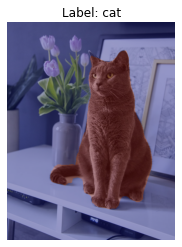

In [10]:
img_show = cat_resized.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0) # 예측 중 사람만 추출
cat_mask = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization, 원본이미지에 그림형태로 출력하기 위해
cat_mask =cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET) # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("Label: cat")
plt.axis('off')
plt.show()

Deeplab 모델을 사용하기 위해 resize했던 세그맨테이션 결과(mask)를 원래 크기로 복원한다.

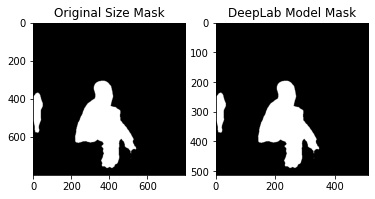

In [11]:
person_mask_up = cv2.resize(person_mask, person_org.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 
# 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
_, person_mask_up = cv2.threshold(person_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(person_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(person_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

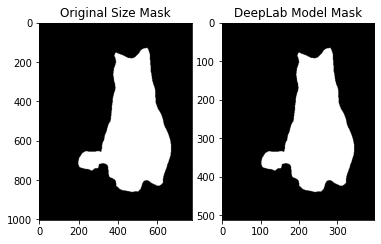

In [12]:
cat_mask_up = cv2.resize(cat_mask, cat_org.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 
# 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 1.3 Blurring
1. `blur()` 함수를 이용해서 배경을 흐리게 만든다.
2. 흐려진 이미지에서 세그맨테이션 마스크를 이용해 배경만 추출한다.
3. 배경과 객체 mask를 합성한다.

In [13]:
def Blur_image(img_orig, img_mask_up):
    
    plt.figure(figsize=(18,5))
    
    # 사진 흐리게
    ax = plt.subplot(1,3,1)
    img_orig_blur = cv2.blur(img_orig, (13,13)) # blurring  kernel size:(13,13)
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.title('Blurred Image')
    plt.axis('off')

    # 배경 추출
    ax = plt.subplot(1,3,2)
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 (배경:255, 사람:0)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.title('Masked Background')
    plt.axis('off')

    # 배경과 mask 합성
    ax = plt.subplot(1,3,3)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title('Combined Images')
    plt.axis('off')
    plt.show()
    return img_concat

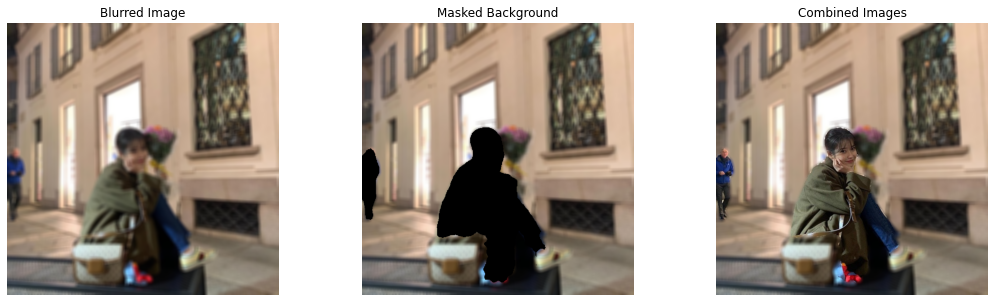

In [14]:
person_concat = Blur_image(person_org, person_mask_up)

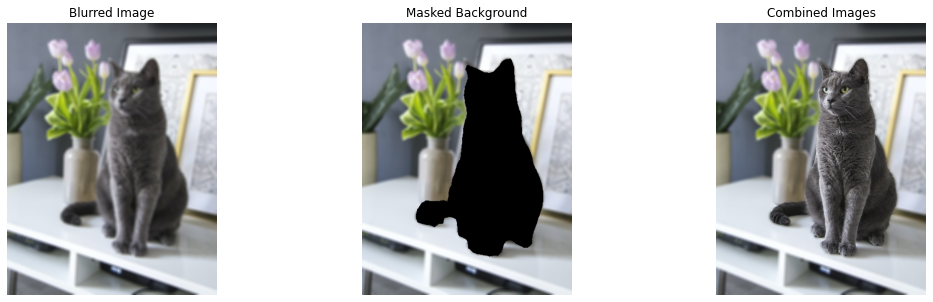

In [15]:
cat_concat = Blur_image(cat_org, cat_mask_up)

## 2. Chromakey Synthesis

### 2.1 Load the Images

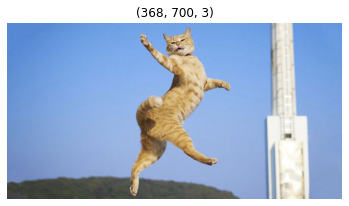

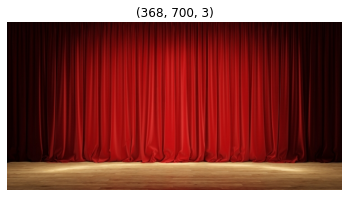

In [16]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
cat_org2 = cv2.imread(img_path + 'dancing_cat.jpg')
bgr_org = cv2.imread(img_path + 'bgr.jpg')

plt.imshow(cv2.cvtColor(cat_org2, cv2.COLOR_BGR2RGB))
plt.title(cat_org2.shape)
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(bgr_org, cv2.COLOR_BGR2RGB))
target_size = (cat_org2.shape[1], cat_org2.shape[0])
bgr_resized = cv2.resize(bgr_org, target_size)
plt.title(bgr_resized.shape)
plt.axis('off')
plt.show()

### 2.2 Semantic segmentation

In [17]:
cat_resized2, seg_map_cat2 = MODEL.run(cat_org2)
print (cat_org2.shape, cat_resized2.shape, seg_map_cat2.max())

(368, 700, 3) (269, 513, 3) 8


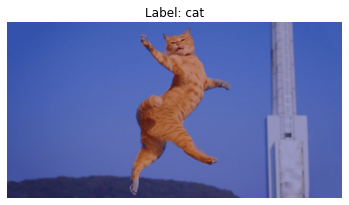

In [18]:
img_show = cat_resized2.copy()
seg_map_cat2 = np.where(seg_map_cat2 == 8, 8, 0) # 예측 중 사람만 추출
cat_mask2 = seg_map_cat2 * (255/seg_map_cat2.max()) # 255 normalization, 원본이미지에 그림형태로 출력하기 위해
cat_mask2 = cat_mask2.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask2, cv2.COLORMAP_JET) # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("Label: cat")
plt.axis('off')
plt.show()

In [19]:
# resize mask
cat_mask_up2 = cv2.resize(cat_mask2, cat_org2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 
_, cat_mask_up2 = cv2.threshold(cat_mask_up2, 128, 255, cv2.THRESH_BINARY)

### 2.3 Combine images

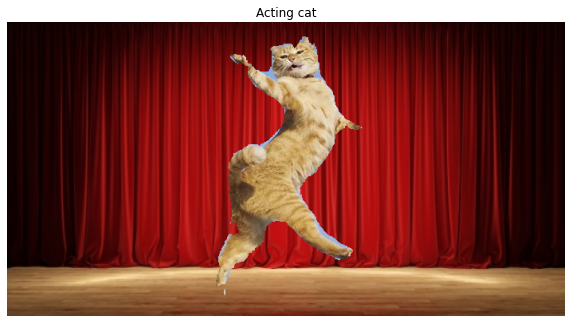

In [20]:
# 배경과 원본 mask 합성 후 저장
img_mask_color = cv2.cvtColor(cat_mask_up2, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, cat_org2, bgr_resized)
save_path = os.path.join(img_path, 'actor_cat.jpg')
cv2.imwrite(save_path, img_concat)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("Acting cat")
plt.axis('off')
plt.show()

연극하는 고양이사진을 만들었다🤣

## 3. Limitations of Image Segmentation

In [21]:
from matplotlib import font_manager
font_fname = os.getenv('HOME')+'/aiffel/font/NanumSquareRoundB.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

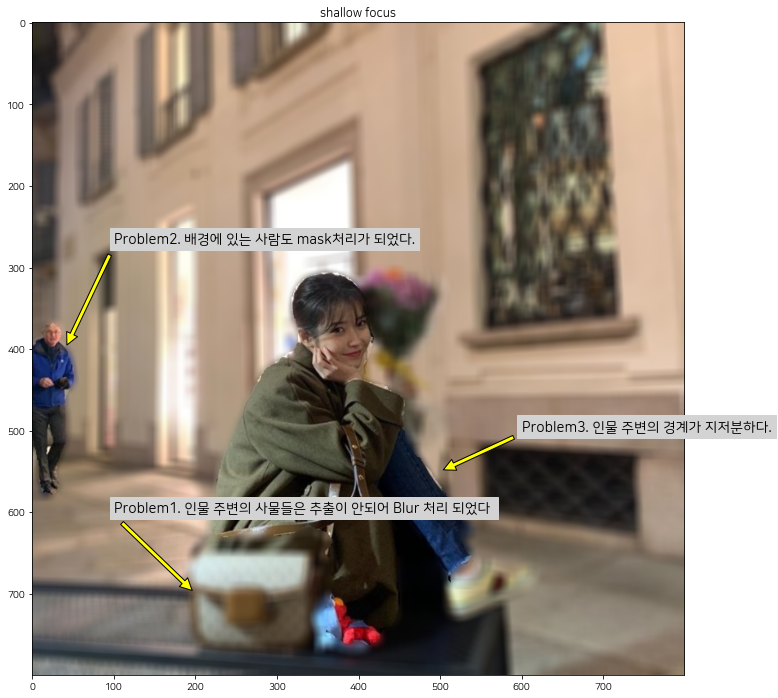

In [22]:
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(person_concat, cv2.COLOR_BGR2RGB))
plt.title('shallow focus')
plt.axis('off')

# annotations
arrowprops=dict(facecolor='Yellow', shrink=0.04)
bbox=dict(boxstyle='square', color='lightgray')
plt.annotate("Problem1. 인물 주변의 사물들은 추출이 안되어 Blur 처리 되었다 ", xy=(200, 700),xytext=(100,600),fontsize=14,bbox=bbox,arrowprops=arrowprops)
plt.annotate("Problem2. 배경에 있는 사람도 mask처리가 되었다.", xy=(40, 400),xytext=(100,270),fontsize=14,bbox=bbox,arrowprops=arrowprops)
plt.annotate("Problem3. 인물 주변의 경계가 지저분하다.", xy=(500, 550),xytext=(600,500),fontsize=14,bbox=bbox,arrowprops=arrowprops)

plt.show()

지금까지 진행한 아웃포커싱과 크로마키 합성 이미지에서 다음과 같은 문제들을 찾아냈다.
1. 인물 주변의 사물들은 같은 위치 상에 있어 함께 추출되기를 바랐지만 semantic segmentation이 인물에 속하는 부분이 아니라 판단하여 배경과 같이 흐리게 처리 되었다.
2. 배경에 있는 인물이 `person` 라벨로 분류되어 mask 처리가 되었고, 선명한 이미지로 보이게 처리 되었다.
3. mask된 객체의 경계가 깔끔하지 않아 경계를 자연스럽게 처리 해 줄 필요성이 있다.

## 4. Possible solutions

### solution 1 depth map을 이용하여 defocusing하기

Depth Estimation으로 깊이의 최저와 최고점을 지정하여 지정된 범위안에 속한 객체를 추출해주는 기법이다. 이를 이용하여 초점을 맞추고 싶은 객체를 지정해주면 원하는 depth만큼 앞에 있는 객체들을 분리 할 수 있으며, 분리한 객체를 mask 하여 배경을 blur 처리해주면 클래스가 상이해도 같은 위치상에 있는 신발, 가방등도 함께 추출할 수 있어 원하는 아웃포커싱 효과를 만들어낼 수 있다.
(참고:https://velog.io/@dldydldy75/3D-Understanding#shapenet)

### Solution 2. Instance segmentation

Semantic segmentatin은 class 단위로 객체를 인식하기 때문에 원하는 사람만 선택 할 수가 없다는 문제가 있다. Instance segmetation 모델인 Mask R-CNN을 이용해 동일 class에서 원하는 사람만 지정하여 아웃포커싱을 수행해본다.
(참고: https://blog.paperspace.com/mask-r-cnn-tensorflow-2-0-keras/)

> __Image Segmentation__<br>
여러 세부 태스크에 따라 다양한 기준으로 객체를 추출하는 것.
모든 픽셀에 라벨을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다.

> __Semantic segmentation__<br>
물리적 의미 단위로 인식하는 세그멘테이션.
![semantic segmentation](https://divamgupta.com/assets/images/posts/imgseg/teaser.png)

> __Instance segmentation__<br>
시맨틱 세그맨테이션은 사람이면 누구든지 같은 라벨로 표현된다.
인스턴스 세그멘테이션은 더 나아가 개인별로 다른 라벨을 가지게 한다.

mrcnn은 tensorflow 1.3버전에서 사용할 수 있어서 가상환경을 생성하여 requirements.txt를 기준으로 필요한 라이브러리들을 준비하였다.

In [23]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
from mrcnn import utils
import cv2
import os

ModuleNotFoundError: No module named 'mrcnn'

In [ ]:
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath="mask_rcnn_coco.h5", 
                   by_name=True)

image = cv2.imread("sample2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

r = model.detect([image], verbose=0)

r = r[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

가상환경 세팅에 문제가 있어...추후 진행해야 겠다...

### Solution 3. Border smoothing

GaussianBlur는 전체적으로 밀도가 동일한 노이즈를 우수하게 제거하는 블러 함수이다. 이를 이용하여 합성시 생기는 테두리의 문제점을 해결해본다.<br>(참고:https://076923.github.io/posts/C-opencv4-14/)

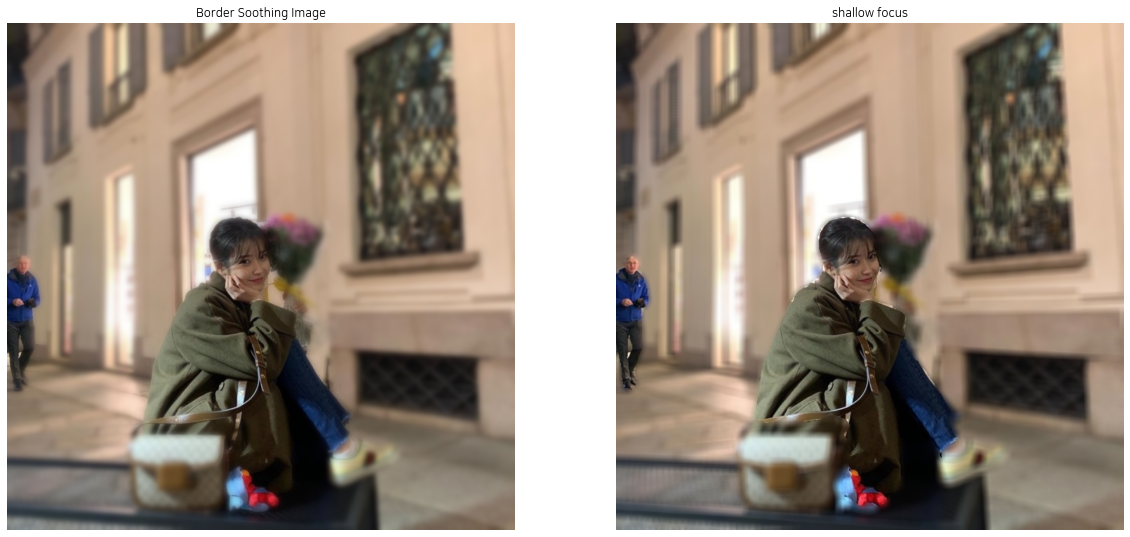

In [42]:
seg_map_person = np.where(seg_map_person == 15, 15, 0) # 예측 중 사람만 추출
person_mask = seg_map_person * (255/seg_map_person.max()) # 255 normalization, 원본이미지에 그림형태로 출력하기 위해
person_mask = person_mask.astype(np.uint8)

# 원본 사진과 마스크의 크기를 맞춰준다.
person_mask_up = cv2.resize(person_mask, person_org.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 

# 원본 이미지를 가우시안 Blur
person_org_blur = cv2.GaussianBlur(person_org, (25,25),0)
# 마스크 이미지를 가우시안 Blur
person_Gmask = (cv2.GaussianBlur(person_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 합친다
person_image_blur = person_Gmask*person_org.astype(np.float32)

person_bg_mask = (1-person_Gmask)*person_org_blur.astype(np.float32) # 1-person_Gmask : 블러처리한 원본에서 배경만 추출
result = (person_image_blur+person_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 
ax = plt.subplot(1,2,1)
ax.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
ax.set_title('Border Soothing Image')
ax.axis('off')

ax = plt.subplot(1,2,2)
ax.imshow(cv2.cvtColor(person_concat, cv2.COLOR_BGR2RGB))
ax.set_title('shallow focus')
ax.axis('off')
plt.show()

경계가 훨씬 자연스러워졌다!😊

***

## Project Review

- 인물사진과 고양이의 아웃포커싱과 크로마키 합성을 진행하였다.
- 완성된 사진에서 문제점을 찾는 작업까지는 수월하였으나 해결방법을 찾는 과정에서 시행착오를 많이 겪었다.
- 특히 mrcnn 모델은 tensorflow 1.13.1버전이 필요했고 처음에는 downgrade 시키면 되겠지..하는 가벼운 마음으로 수행했으나 필요한 라이브러리들이 클라우드에 세팅되어있는 것들과 버전이 크게 상이하고 각 라이브러리들끼리 충돌하는 현상이 계속 나타났다.
- tensorflow 2버전으로 모델 코드를 수정하는 내용도 찾아 적용해봤지만 하나 해결할때마다 새로운 에러메시지가 계속 떠서 결국 가상환경을 세팅해야겠다고 마음먹었다.
- 로컬 PC 아나콘다를 이용해 가상환경을 만들었고 필요 라이브러리 버전까지 한번에 맞춰 세팅해두었다. (참고:https://ecogis.tistory.com/49?category=908345)
- 그러나 git에서 다운받은 모델에 pre-trained weight가 없어 따로 다운받았고, 디렉토리 연결하는데서 또 문제가 발생하였다....😰(미해결)
- 이미지 경계처리에는 openCV에서 제공하는 함수를 이용해서 경계를 자연스럽게 만들어 주었다.
- 클래스별로 분리되어 같은 위치상인데도 흐림처리가 되었던 물건들의 문제는 Depth Estimation으로 해결할 수 있을 것 같다. 블로그에서 관련된 정보는 찾았으나 바로 적용해볼수 있는 모델이나 라이브러리는 못찾아서 수행하는데에는 좀 더 조사할 필요가 있다.